In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
spark = SparkSession.builder.appName("feature_importance").getOrCreate()

df = spark.read.csv("final_10.csv", header=True, inferSchema=True)

In [3]:
target_col = "Accident_Severity"
feature_cols = [col for col in df.columns if col != target_col]

categorical_cols = [
    "Police_Force", "Day_of_Week", "Local_Authority_(District)","Local_Authority_(Highway)",
    "1st_Road_Class", "Road_Type", "Junction_Detail", "Junction_Control",
    "2nd_Road_Class", "Pedestrian_Crossing_Human_Control",
    "Pedestrian_Crossing_Physical_Facilities", "Light_Conditions",
    "Weather_Conditions", "Road_Surface_Conditions",
    "Special_Conditions_at_Site", "Carriageway_Hazards",
    "Urban_or_Rural_Area", "Did_Police_Officer_Attend_Scene_of_Accident",
    "Casualty_Class", "Sex_of_Casualty", "Age_Band_of_Casualty",
    "Casualty_Severity", "Pedestrian_Location", "Pedestrian_Movement",
    "Car_Passenger", "Bus_or_Coach_Passenger",
    "Pedestrian_Road_Maintenance_Worker", "Casualty_Type",
    "Casualty_Home_Area_Type", "Vehicle_Type", "Towing_and_Articulation",
    "Vehicle_Manoeuvre", "Vehicle_Location_Restricted_Lane",
    "Junction_Location", "Skidding_and_Overturning",
    "Hit_Object_in_Carriageway", "Vehicle_Leaving_Carriageway",
    "Hit_Object_off_Carriageway", "1st_Point_of_Impact",
    "Was_Vehicle_Left_Hand_Drive?", "Journey_Purpose_of_Driver",
    "Sex_of_Driver", "Age_Band_of_Driver", "Propulsion_Code",
    "Driver_Home_Area_Type"
]

numerical_cols = [
    'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 'Latitude',
    'Number_of_Vehicles', 'Number_of_Casualties', 'Speed_limit', 'Age_of_Casualty',
    'Age_of_Driver', 'Engine_Capacity_(CC)', 'Age_of_Vehicle', 'Driver_IMD_Decile'
]

In [4]:
filtered_categorical_cols = []
for col_name in categorical_cols:
    n_unique = df.select(col_name).distinct().count()
    print(f"{col_name}: {n_unique} unikátnych hodnôt")
    if n_unique <= 100:
        filtered_categorical_cols.append(col_name)
    else:
        print(f"Vyradený kvôli vysokému počtu tried: {col_name}")

Police_Force: 51 unikátnych hodnôt
Day_of_Week: 7 unikátnych hodnôt
Local_Authority_(District): 416 unikátnych hodnôt
Vyradený kvôli vysokému počtu tried: Local_Authority_(District)
Local_Authority_(Highway): 207 unikátnych hodnôt
Vyradený kvôli vysokému počtu tried: Local_Authority_(Highway)
1st_Road_Class: 6 unikátnych hodnôt
Road_Type: 6 unikátnych hodnôt
Junction_Detail: 9 unikátnych hodnôt
Junction_Control: 5 unikátnych hodnôt
2nd_Road_Class: 6 unikátnych hodnôt
Pedestrian_Crossing_Human_Control: 3 unikátnych hodnôt
Pedestrian_Crossing_Physical_Facilities: 6 unikátnych hodnôt
Light_Conditions: 5 unikátnych hodnôt
Weather_Conditions: 9 unikátnych hodnôt
Road_Surface_Conditions: 5 unikátnych hodnôt
Special_Conditions_at_Site: 8 unikátnych hodnôt
Carriageway_Hazards: 6 unikátnych hodnôt
Urban_or_Rural_Area: 3 unikátnych hodnôt
Did_Police_Officer_Attend_Scene_of_Accident: 3 unikátnych hodnôt
Casualty_Class: 3 unikátnych hodnôt
Sex_of_Casualty: 2 unikátnych hodnôt
Age_Band_of_Casualty:

In [5]:
def find_feature_importance(use_filtered: bool, maxBins: int, exclude_cols: list):
    if exclude_cols is None:
        exclude_cols = []

    # Výber kategórií podľa prepínača
    cat_cols = filtered_categorical_cols if use_filtered else categorical_cols
    # Odstránenie vyradených stĺpcov z kategorizovaných a numerických
    cat_cols = [col for col in cat_cols if col not in exclude_cols]
    num_cols = [col for col in numerical_cols if col not in exclude_cols]

    print(f"Použité kategórie: {cat_cols}")
    print(f"Použité numerické: {num_cols}")
    print(f"Vyradené atribúty: {exclude_cols}")

    # Indexovanie kategórií
    indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid="keep") for col in cat_cols]
    indexed_features = [f"{col}_indexed" for col in cat_cols] + num_cols

    # Index cieľa
    label_indexer = StringIndexer(inputCol=target_col, outputCol="label", handleInvalid="keep")

    # Assembler a model
    assembler = VectorAssembler(inputCols=indexed_features, outputCol="features", handleInvalid="skip")
    dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=5, maxBins=maxBins)

    # Pipeline
    pipeline = Pipeline(stages=indexers + [label_indexer, assembler, dt])
    model = pipeline.fit(df)
    dt_model = model.stages[-1]

    # Výpočet feature importance
    importances = dt_model.featureImportances.toArray()
    feature_scores = sorted(zip(indexed_features, importances), key=lambda x: x[1], reverse=True)
    df_log = pd.DataFrame(feature_scores, columns=["Feature", "Importance"])

    # Vizualizácia
    top_k = len(feature_scores)
    top_features = df_log.head(top_k)
    plt.figure(figsize=(30, 15))
    plt.barh(top_features["Feature"], top_features["Importance"], color="salmon")
    plt.gca().invert_yaxis()
    plt.title(f"Feature Importances pre Accidents_Severity ({'filtered' if use_filtered else 'all'})")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

    # Logovanie
    suffix = "filtered" if use_filtered else "all"
    log_path = f"feature_importance_decision_tree_log_{suffix}.csv"
    df_log.to_csv(log_path, index=False)
    print(f"Log uložený do: {os.path.abspath(log_path)}")

Použité kategórie: ['Police_Force', 'Day_of_Week', 'Local_Authority_(District)', 'Local_Authority_(Highway)', '1st_Road_Class', 'Road_Type', 'Junction_Detail', 'Junction_Control', '2nd_Road_Class', 'Pedestrian_Crossing_Human_Control', 'Pedestrian_Crossing_Physical_Facilities', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident', 'Casualty_Class', 'Sex_of_Casualty', 'Age_Band_of_Casualty', 'Pedestrian_Location', 'Pedestrian_Movement', 'Car_Passenger', 'Bus_or_Coach_Passenger', 'Pedestrian_Road_Maintenance_Worker', 'Casualty_Type', 'Casualty_Home_Area_Type', 'Vehicle_Type', 'Towing_and_Articulation', 'Vehicle_Manoeuvre', 'Vehicle_Location_Restricted_Lane', 'Junction_Location', 'Skidding_and_Overturning', 'Hit_Object_in_Carriageway', 'Vehicle_Leaving_Carriageway', 'Hit_Object_off_Carriageway', '1st_Point_of_Impact', 'Was_Vehicle_Left_Hand_Drive?', 'Jou

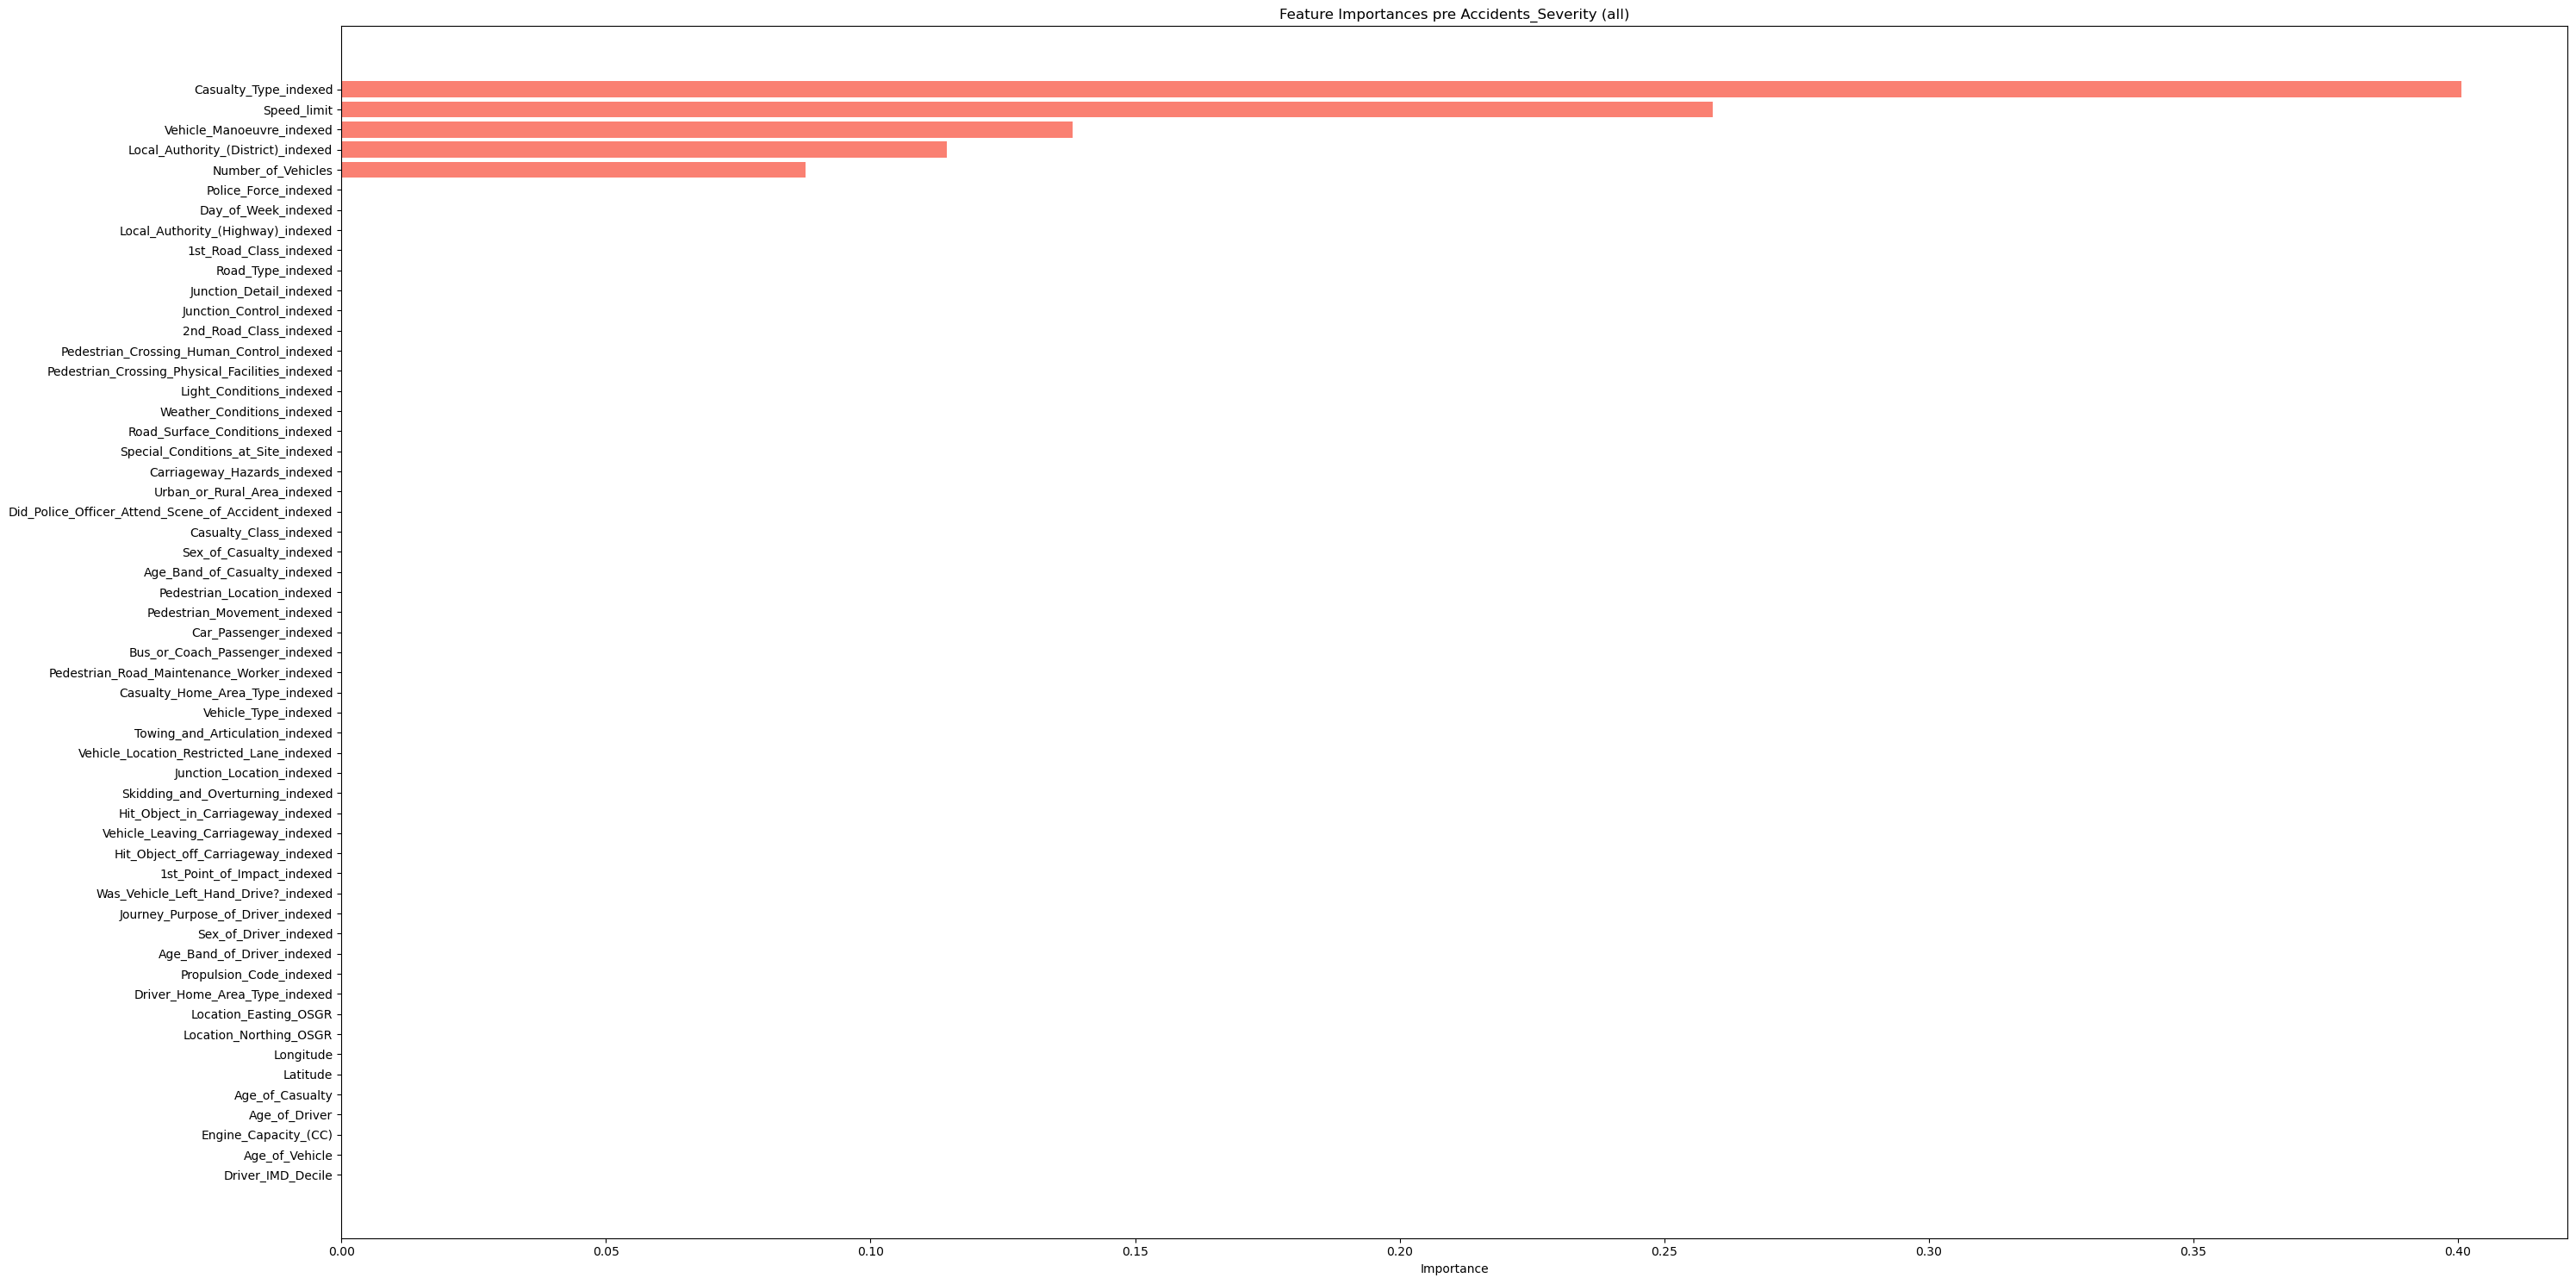

Log uložený do: /home/jovyan/work/TSVD_zadanie-main/feature_importance_decision_tree_log_all.csv
Použité kategórie: ['Police_Force', 'Day_of_Week', '1st_Road_Class', 'Road_Type', 'Junction_Detail', 'Junction_Control', '2nd_Road_Class', 'Pedestrian_Crossing_Human_Control', 'Pedestrian_Crossing_Physical_Facilities', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident', 'Casualty_Class', 'Sex_of_Casualty', 'Age_Band_of_Casualty', 'Pedestrian_Location', 'Pedestrian_Movement', 'Car_Passenger', 'Bus_or_Coach_Passenger', 'Pedestrian_Road_Maintenance_Worker', 'Casualty_Type', 'Casualty_Home_Area_Type', 'Vehicle_Type', 'Towing_and_Articulation', 'Vehicle_Manoeuvre', 'Vehicle_Location_Restricted_Lane', 'Junction_Location', 'Skidding_and_Overturning', 'Hit_Object_in_Carriageway', 'Vehicle_Leaving_Carriageway', 'Hit_Object_off_Carriageway', '1st_Point_of_Impact'

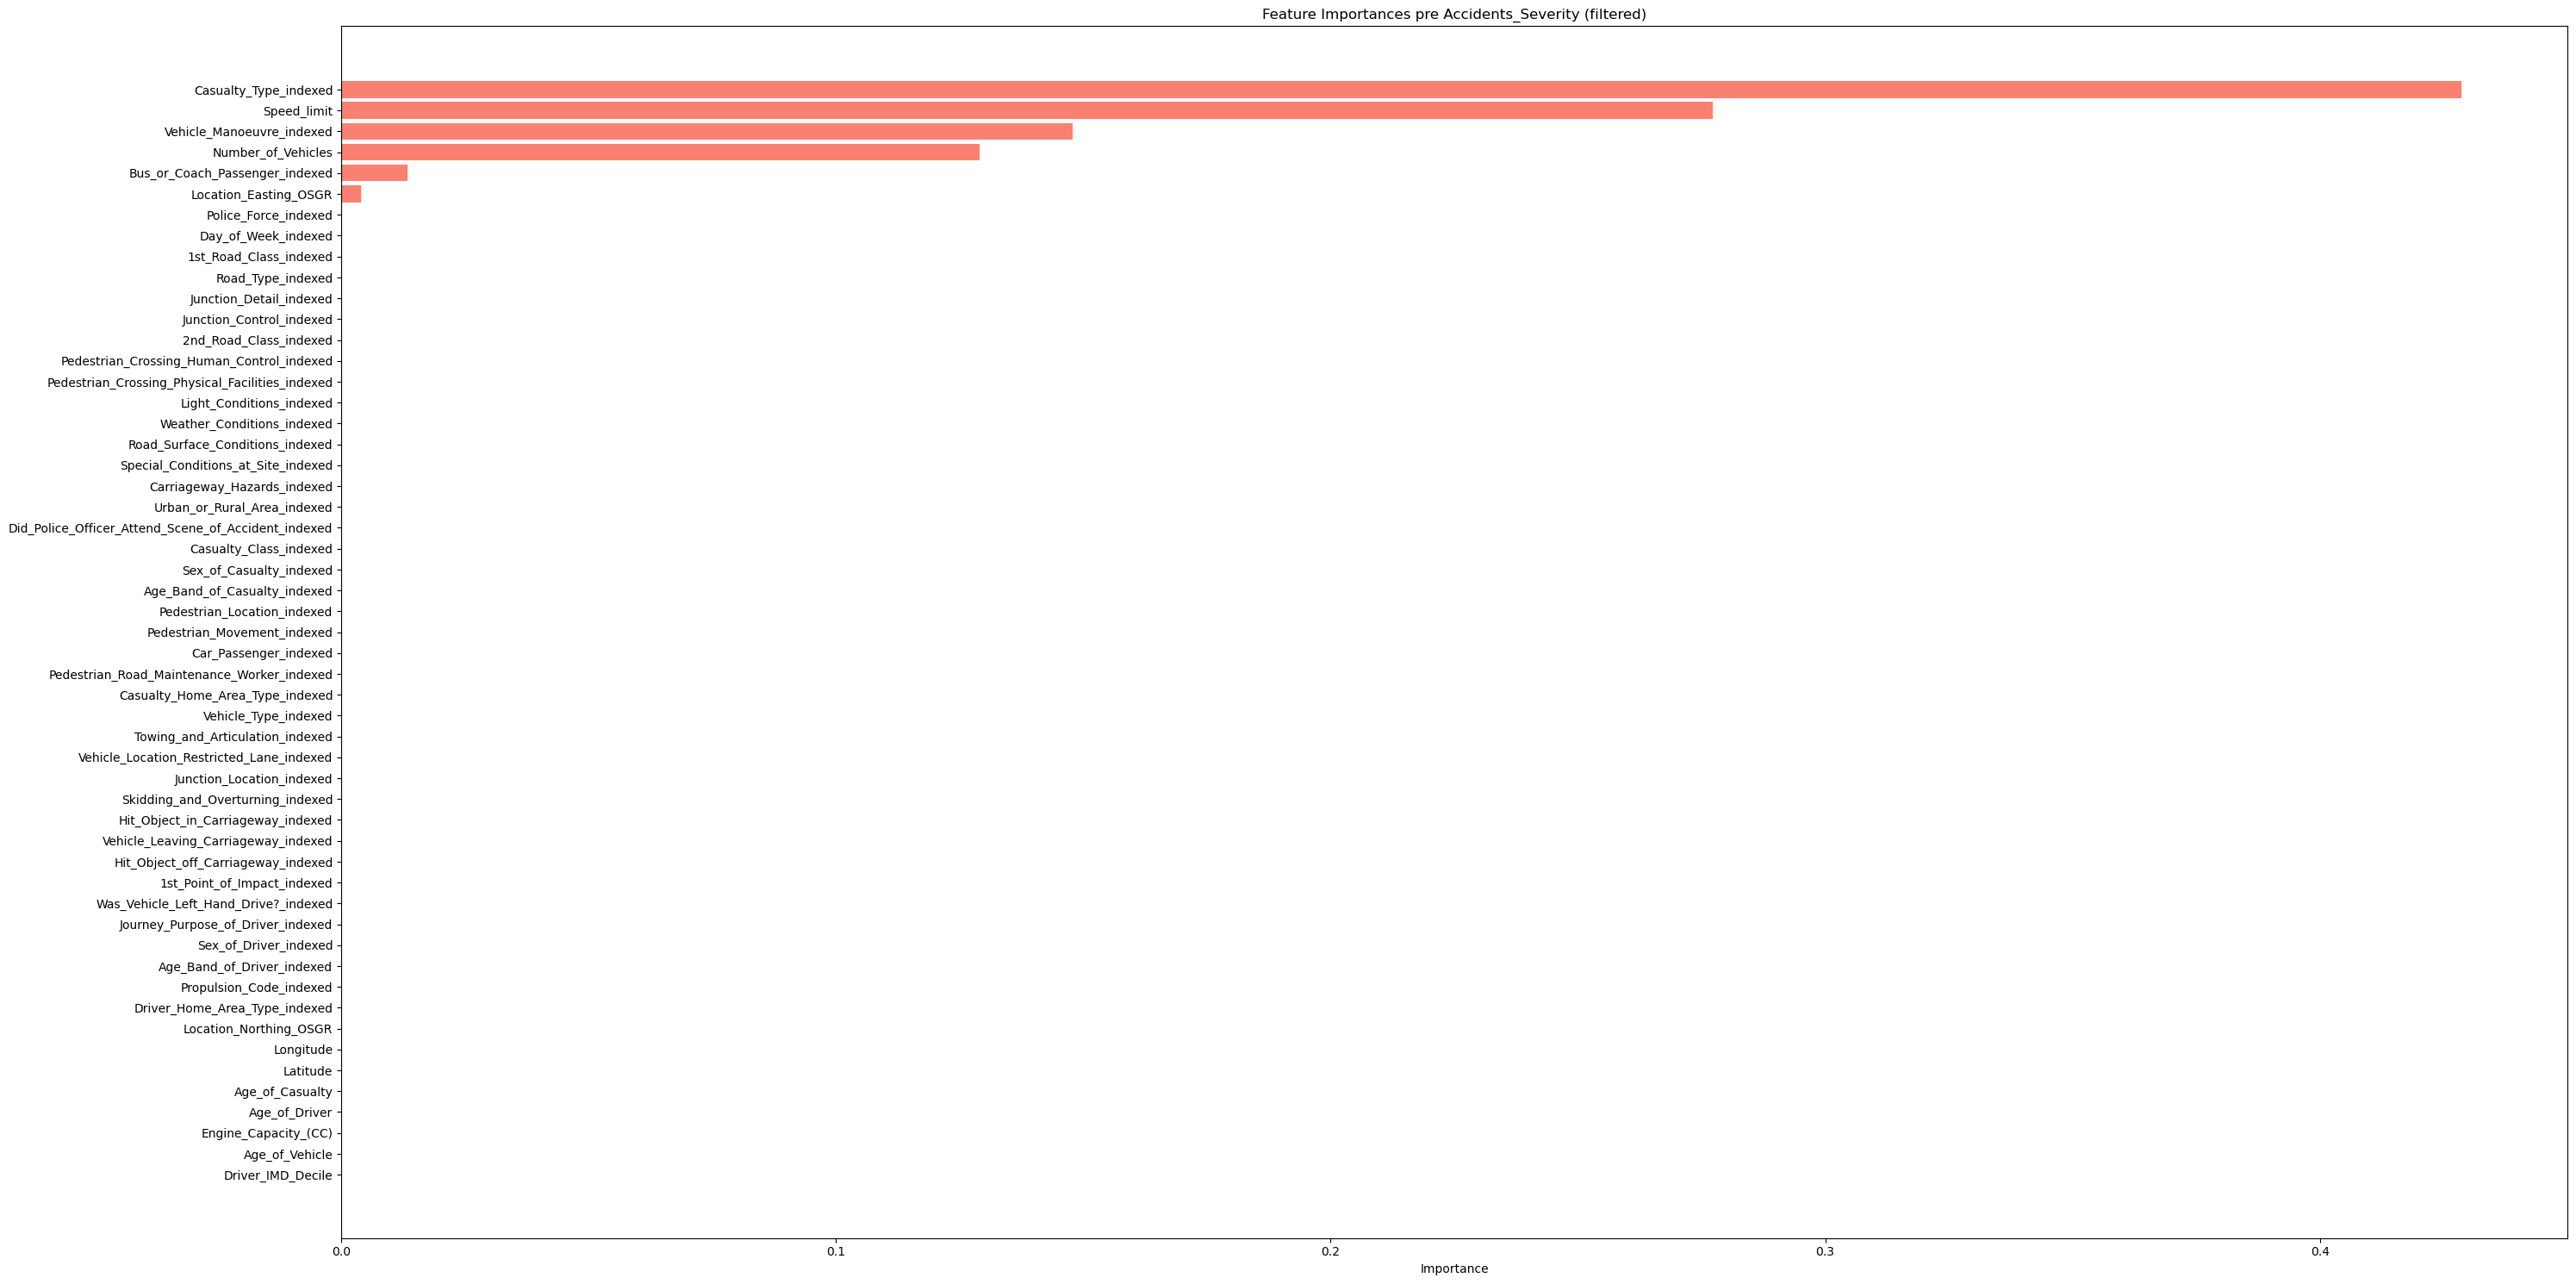

Log uložený do: /home/jovyan/work/TSVD_zadanie-main/feature_importance_decision_tree_log_filtered.csv


In [6]:
feature_importnance_excluded = find_feature_importance(use_filtered=False, maxBins=1000, exclude_cols=["Casualty_Severity","Number_of_Casualties"])
feature_importnance_filtered_excluded = find_feature_importance(use_filtered=True, maxBins=100, exclude_cols=["Casualty_Severity","Number_of_Casualties"])

Použité kategórie: ['Police_Force', 'Day_of_Week', 'Local_Authority_(District)', 'Local_Authority_(Highway)', '1st_Road_Class', 'Road_Type', 'Junction_Detail', 'Junction_Control', '2nd_Road_Class', 'Pedestrian_Crossing_Human_Control', 'Pedestrian_Crossing_Physical_Facilities', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident', 'Casualty_Class', 'Sex_of_Casualty', 'Age_Band_of_Casualty', 'Casualty_Severity', 'Pedestrian_Location', 'Pedestrian_Movement', 'Car_Passenger', 'Bus_or_Coach_Passenger', 'Pedestrian_Road_Maintenance_Worker', 'Casualty_Type', 'Casualty_Home_Area_Type', 'Vehicle_Type', 'Towing_and_Articulation', 'Vehicle_Manoeuvre', 'Vehicle_Location_Restricted_Lane', 'Junction_Location', 'Skidding_and_Overturning', 'Hit_Object_in_Carriageway', 'Vehicle_Leaving_Carriageway', 'Hit_Object_off_Carriageway', '1st_Point_of_Impact', 'Was_Vehicle_Le

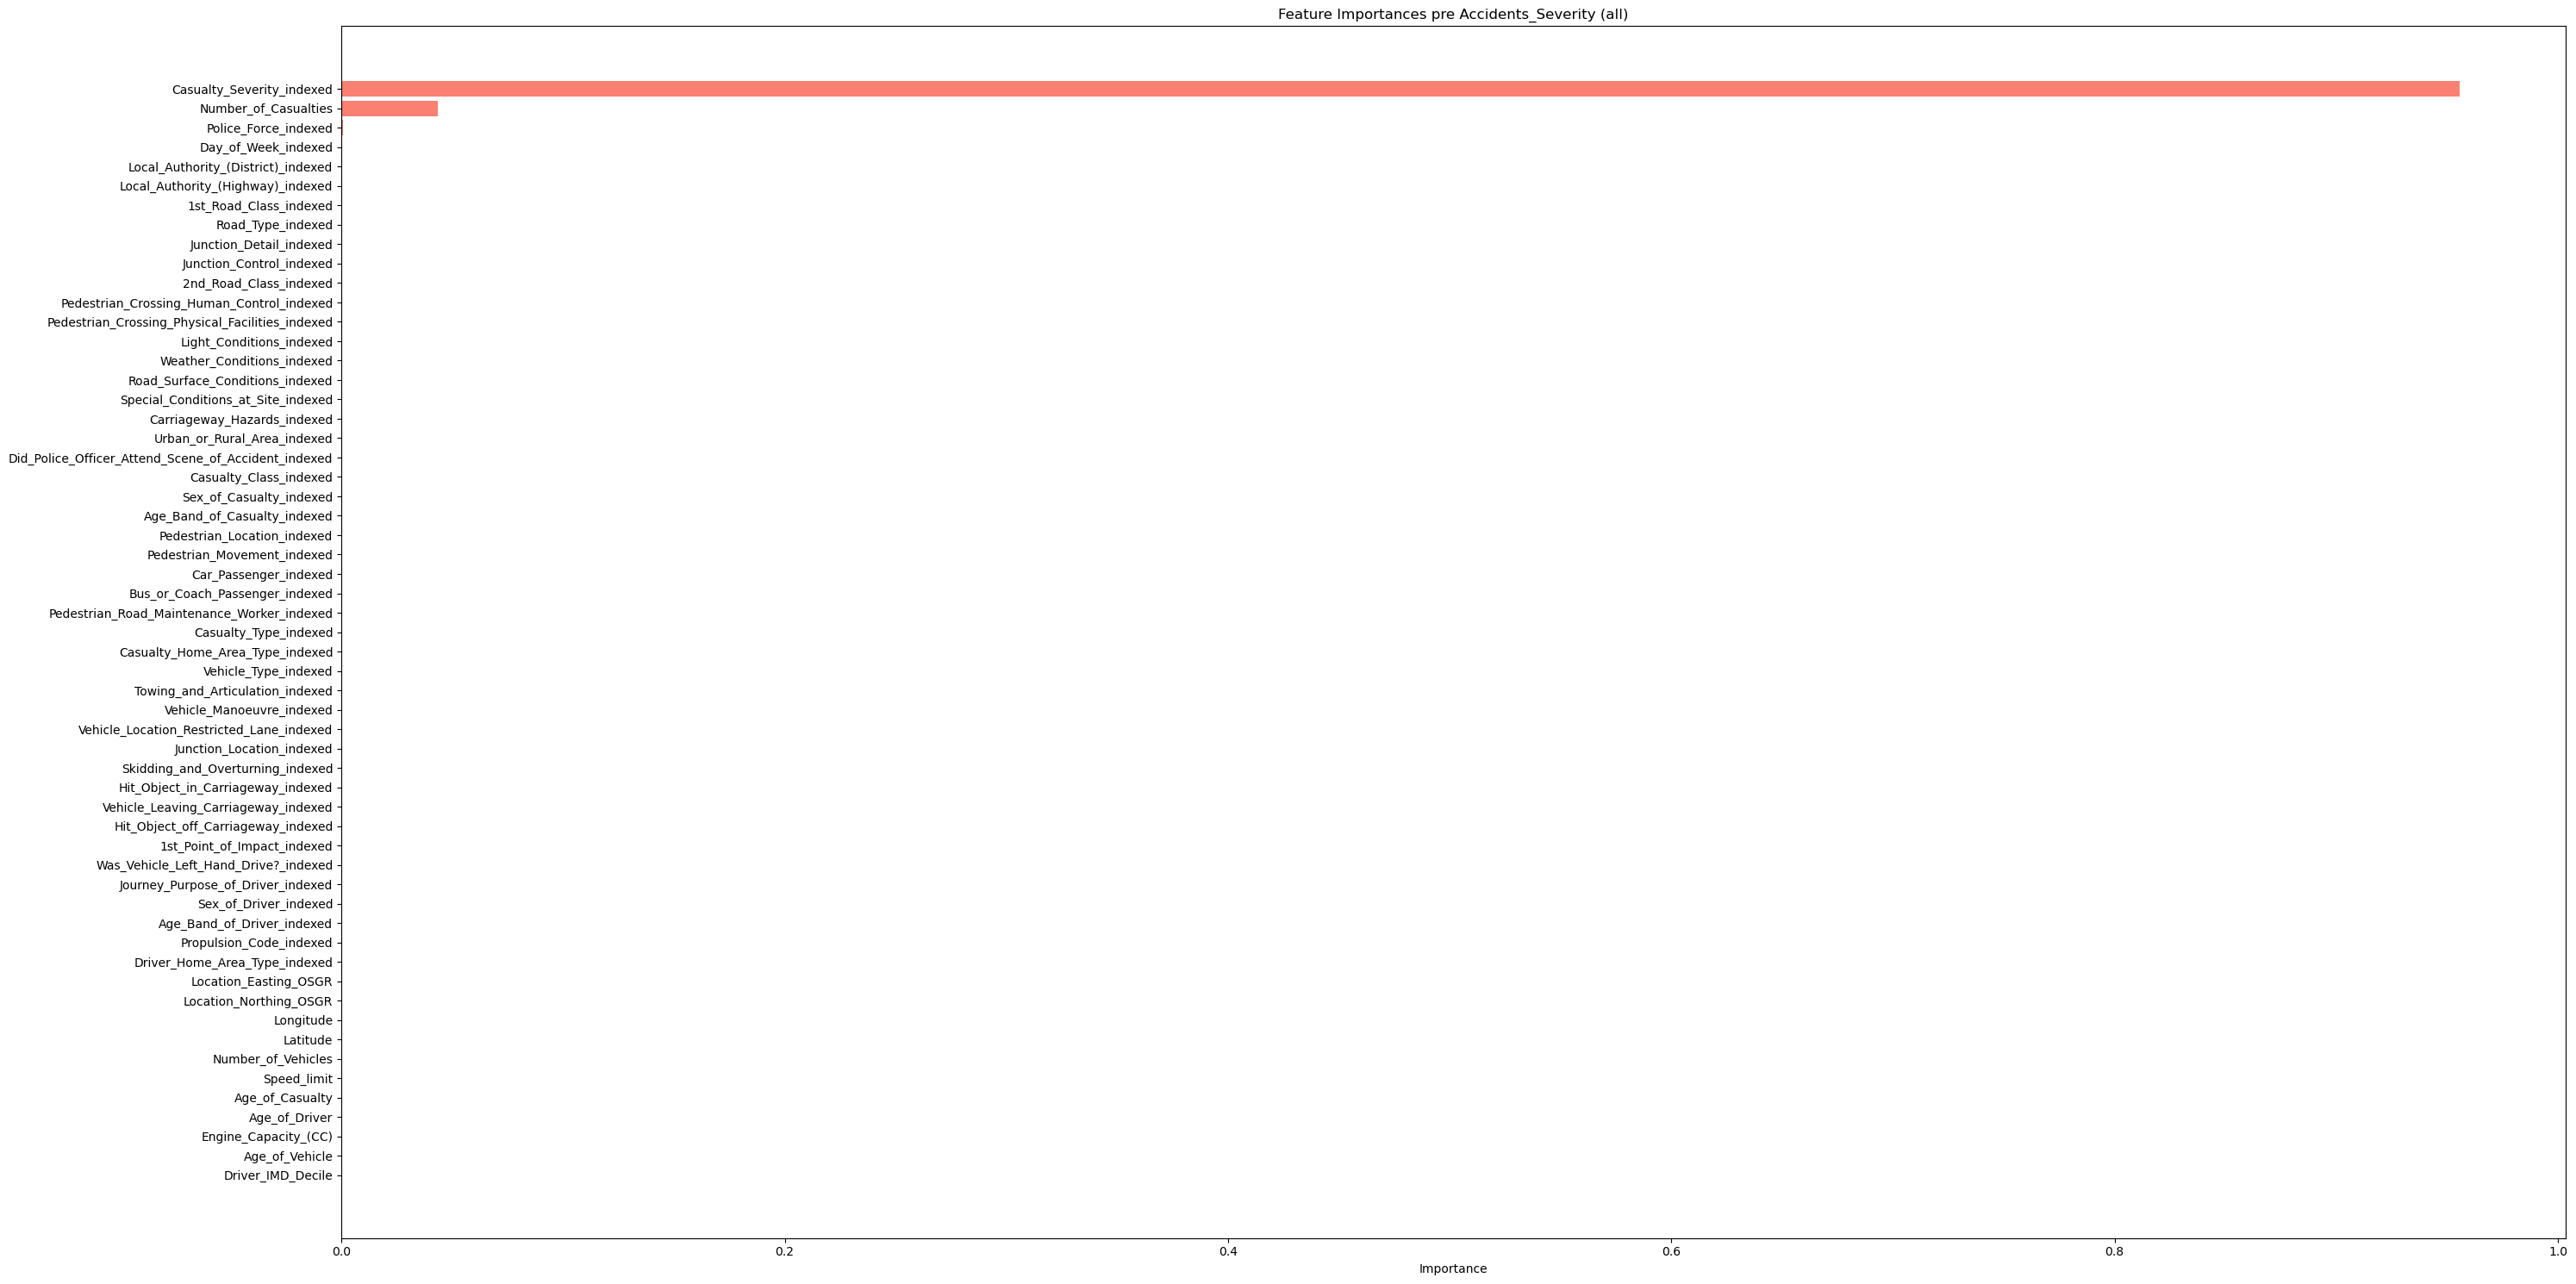

Log uložený do: /home/jovyan/work/TSVD_zadanie-main/feature_importance_decision_tree_log_all.csv
Použité kategórie: ['Police_Force', 'Day_of_Week', '1st_Road_Class', 'Road_Type', 'Junction_Detail', 'Junction_Control', '2nd_Road_Class', 'Pedestrian_Crossing_Human_Control', 'Pedestrian_Crossing_Physical_Facilities', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident', 'Casualty_Class', 'Sex_of_Casualty', 'Age_Band_of_Casualty', 'Casualty_Severity', 'Pedestrian_Location', 'Pedestrian_Movement', 'Car_Passenger', 'Bus_or_Coach_Passenger', 'Pedestrian_Road_Maintenance_Worker', 'Casualty_Type', 'Casualty_Home_Area_Type', 'Vehicle_Type', 'Towing_and_Articulation', 'Vehicle_Manoeuvre', 'Vehicle_Location_Restricted_Lane', 'Junction_Location', 'Skidding_and_Overturning', 'Hit_Object_in_Carriageway', 'Vehicle_Leaving_Carriageway', 'Hit_Object_off_Carriageway', 

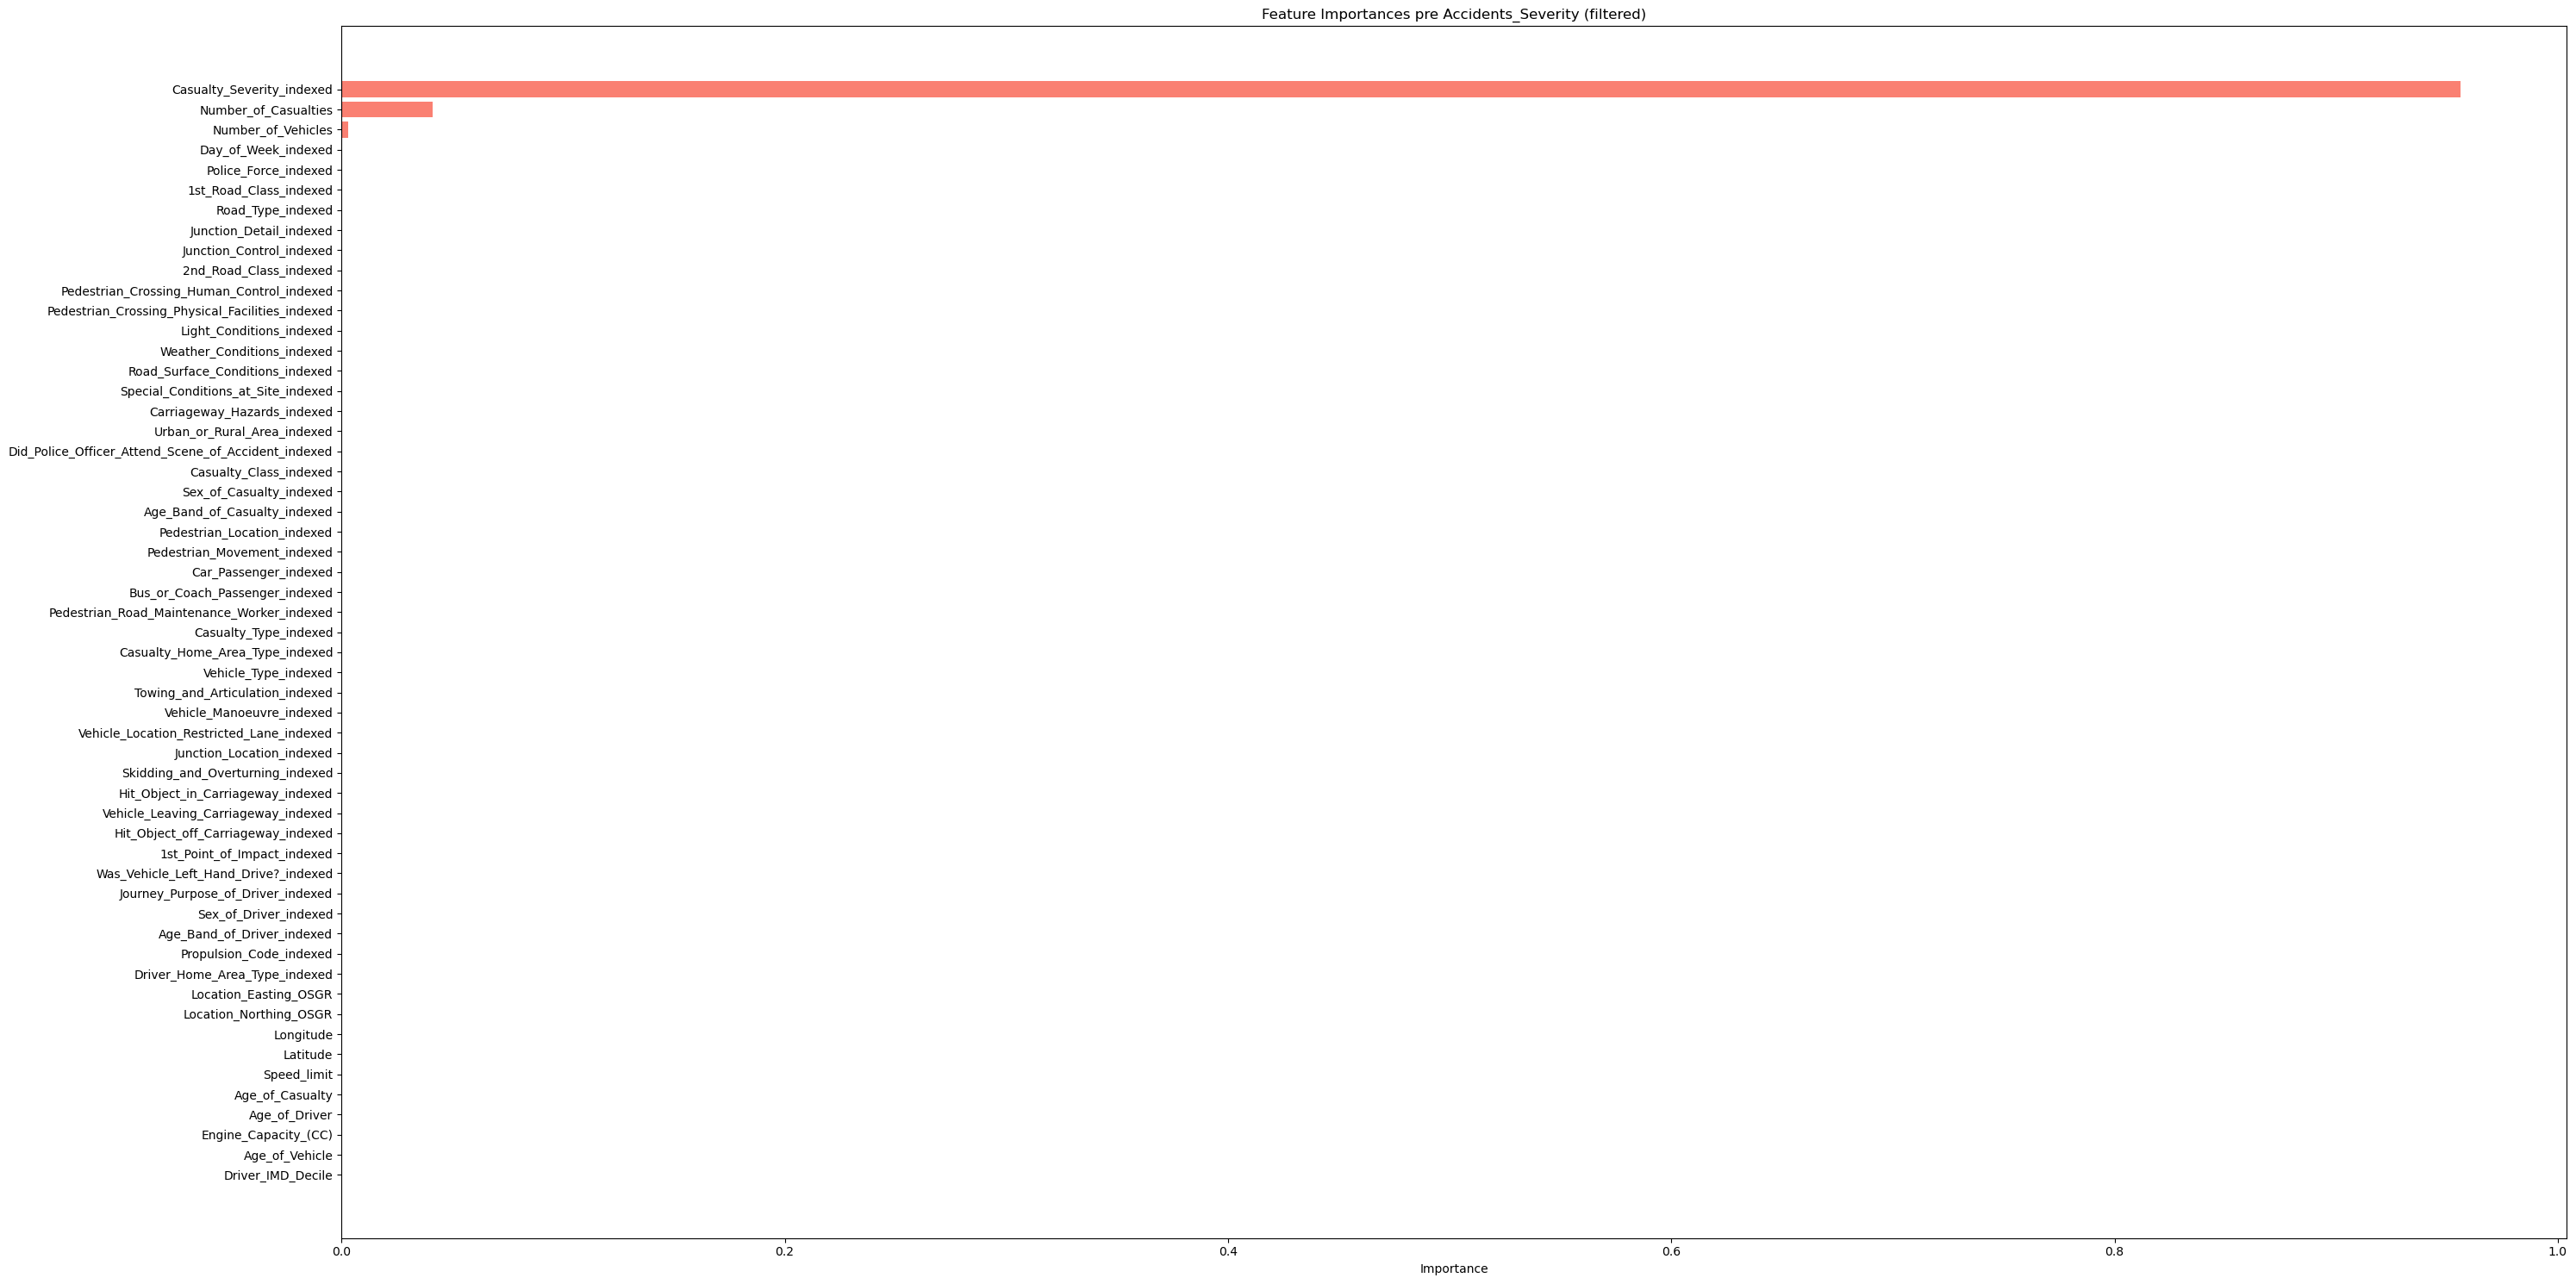

Log uložený do: /home/jovyan/work/TSVD_zadanie-main/feature_importance_decision_tree_log_filtered.csv


In [7]:
feature_importnance = find_feature_importance(use_filtered=False, maxBins=1000, exclude_cols=None)
feature_importnance_filtered = find_feature_importance(use_filtered=True, maxBins=100, exclude_cols=None)